In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 12)

import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

import FinanceDataReader as fdr
import ta

In [122]:
data = pd.read_csv("stock_info.csv", encoding = 'cp949')
data = data.query("시가총액 > 20000000000000")[["종목코드", "종목명", "시가총액"]]
data = data.sort_values(by = "시가총액", ascending = False).reset_index(drop = True)
data

,종목코드,종목명,시가총액
0,005930,삼성전자,462658147625000
1,000660,SK하이닉스,126818011983000
2,373220,LG에너지솔루션,91026000000000
3,207940,삼성바이오로직스,55586894000000
4,005935,삼성전자우,53652212840000
5,005380,현대차,52563463941000
6,000270,기아,47441215954000
7,068270,셀트리온,41211405018000
8,005490,POSCO홀딩스,34251348150000
9,105560,KB금융,30505437043200


In [123]:
# Hyperparameter
k = 5
MA = '5MA' # 5MA, 20MA, 60MA, 120MA

#RMI
def calculate_rmi(df, period):
    delta = df["Close"].diff(5)
    delta = delta.dropna()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    AVG_Gain = up.rolling(window = period).mean()
    AVG_Loss = abs(down.rolling(window = period).mean())
    RM = AVG_Gain / AVG_Loss
    
    df["RMI"] = 100.0 - (100.0 / (1.0 + RM))
    
    return df

evaluate = {}

for code in data["종목코드"] :
    
    lst = []
    
    # Load dataset
    stock = fdr.DataReader(code, start = '2003-01-01').reset_index()

    # 이동평균변수 생성
    period = [5, 20, 60, 120]
    for p in period :
        stock[f"{p}MA"] = stock["Close"].rolling(window = p).mean()   
    stock = stock.iloc[247:, :].reset_index()
    
    # RMI
    calculate_rmi(stock, 5)

    # Fluctuation
    stock.loc[:, "Fluctuation"] = 0
    stock.loc[stock['Change'].shift(-1) >= 0, 'Fluctuation'] = 1

    # 이동평균돌파전략
    df = stock[["Date", "Close", "Change", "Volume", "5MA", "20MA", "60MA", "120MA", "RMI", "Fluctuation"]]
    result1 = []

    for i in range(len(df)):
        if i >= k :
            window_Close = df.loc[i-k:i-1, 'Close']
            window_Volume = df.loc[i-k:i-1, 'Volume']
            window_MA = df.loc[i-k:i-1, MA]
            if all(window_Close < window_MA) and df.loc[i, 'Close'] > df.loc[i, MA] and all(window_Volume < df.loc[i, 'Volume']):
                result1.append(df.loc[i, 'Date'])

    res = df[df['Date'].isin(result1)]["Fluctuation"].mean()
    
    lst.append(round(df["Fluctuation"].mean(), 4))
    lst.append(len(result1))
    lst.append(round(res, 4))

    # RMI 과매도 전략
    result2 = []

    for i in range(len(df)):
        if i >= k :
            window_Close = df.loc[i-k:i-1, 'Close']
            window_Volume = df.loc[i-k:i-1, 'Volume']
            window_MA = df.loc[i-k:i-1, MA]
            window_RMI = df.loc[i-k:i-1, 'RMI']
            if all(window_Volume < df.loc[i, 'Volume']) and all(window_RMI > 30) and df.loc[i, 'RMI'] < 30:
                result2.append(df.loc[i, 'Date'])

    res = df[df['Date'].isin(result2)]["Fluctuation"].mean()

    lst.append(len(result2))
    lst.append(round(res, 4))
    
    evaluate[code] = lst

In [124]:
df = pd.DataFrame(evaluate).T.reset_index()
df.columns = ["종목코드", "전체상승비율", "이동평균돌파일수", "이동평균상승비율", "RMI과매도일수", "RMI과매도상승비율"]
df

,종목코드,전체상승비율,이동평균돌파일수,이동평균상승비율,RMI과매도일수,RMI과매도상승비율
0,005930,0.5258,39.0,0.6154,51.0,0.5686
1,000660,0.5275,34.0,0.7059,39.0,0.6410
2,373220,0.5032,4.0,0.5000,5.0,1.0000
3,207940,0.5091,18.0,0.6667,12.0,0.5000
4,005935,0.5442,38.0,0.5789,48.0,0.5625
5,005380,0.5295,30.0,0.5667,45.0,0.6000
6,000270,0.5259,25.0,0.3200,41.0,0.4878
7,068270,0.5181,13.0,0.5385,15.0,0.4667
8,005490,0.5218,39.0,0.6667,48.0,0.4167
9,105560,0.5072,22.0,0.6818,34.0,0.6471


In [125]:
data = data.merge(df, on = "종목코드")
data

,종목코드,종목명,시가총액,전체상승비율,이동평균돌파일수,이동평균상승비율,RMI과매도일수,RMI과매도상승비율
0,005930,삼성전자,462658147625000,0.5258,39.0,0.6154,51.0,0.5686
1,000660,SK하이닉스,126818011983000,0.5275,34.0,0.7059,39.0,0.6410
2,373220,LG에너지솔루션,91026000000000,0.5032,4.0,0.5000,5.0,1.0000
3,207940,삼성바이오로직스,55586894000000,0.5091,18.0,0.6667,12.0,0.5000
4,005935,삼성전자우,53652212840000,0.5442,38.0,0.5789,48.0,0.5625
5,005380,현대차,52563463941000,0.5295,30.0,0.5667,45.0,0.6000
6,000270,기아,47441215954000,0.5259,25.0,0.3200,41.0,0.4878
7,068270,셀트리온,41211405018000,0.5181,13.0,0.5385,15.0,0.4667
8,005490,POSCO홀딩스,34251348150000,0.5218,39.0,0.6667,48.0,0.4167
9,105560,KB금융,30505437043200,0.5072,22.0,0.6818,34.0,0.6471


In [126]:
data = data[(data['이동평균돌파일수'] >= 10) & (data['RMI과매도일수'] >= 10)].reset_index(drop = True)
data.drop(columns = ["이동평균돌파일수", "RMI과매도일수"], inplace = True)
data

,종목코드,종목명,시가총액,전체상승비율,이동평균상승비율,RMI과매도상승비율
0,005930,삼성전자,462658147625000,0.5258,0.6154,0.5686
1,000660,SK하이닉스,126818011983000,0.5275,0.7059,0.6410
2,207940,삼성바이오로직스,55586894000000,0.5091,0.6667,0.5000
3,005935,삼성전자우,53652212840000,0.5442,0.5789,0.5625
4,005380,현대차,52563463941000,0.5295,0.5667,0.6000
5,000270,기아,47441215954000,0.5259,0.3200,0.4878
6,068270,셀트리온,41211405018000,0.5181,0.5385,0.4667
7,005490,POSCO홀딩스,34251348150000,0.5218,0.6667,0.4167
8,105560,KB금융,30505437043200,0.5072,0.6818,0.6471
9,035420,NAVER,29948144733600,0.5277,0.4483,0.5645


In [142]:
data.drop(5, axis = 0, inplace = True)

In [148]:
data[["종목명", "전체상승비율", "이동평균상승비율"]].sort_values(by = "이동평균상승비율", ascending = False).reset_index(drop = True)

,종목명,전체상승비율,이동평균상승비율
0,SK하이닉스,0.5275,0.7059
1,KB금융,0.5072,0.6818
2,LG화학,0.5273,0.6757
3,삼성바이오로직스,0.5091,0.6667
4,POSCO홀딩스,0.5218,0.6667
5,신한지주,0.5238,0.6410
6,삼성전자,0.5258,0.6154
7,삼성물산,0.5386,0.6000
8,삼성전자우,0.5442,0.5789
9,현대차,0.5295,0.5667


In [149]:
data[["종목명", "전체상승비율", "RMI과매도상승비율"]].sort_values(by = "RMI과매도상승비율", ascending = False).reset_index(drop = True)

,종목명,전체상승비율,RMI과매도상승비율
0,현대모비스,0.5206,0.6667
1,신한지주,0.5238,0.6600
2,KB금융,0.5072,0.6471
3,삼성물산,0.5386,0.6471
4,SK하이닉스,0.5275,0.6410
5,삼성SDI,0.5343,0.6042
6,현대차,0.5295,0.6000
7,삼성전자,0.5258,0.5686
8,NAVER,0.5277,0.5645
9,삼성전자우,0.5442,0.5625


## 개별종목조회

In [121]:
# Hyperparameter
code = '000660'
k = 5
MA = '5MA' # 5MA, 20MA, 60MA, 120MA

# Load dataset
stock = fdr.DataReader(code, start = '2003-01-01').reset_index()

# 이동평균변수 생성
period = [5, 20, 60, 120]
for p in period :
    stock[f"{p}MA"] = stock["Close"].rolling(window = p).mean()   
stock = stock.iloc[247:, :].reset_index()

#RMI
def calculate_rmi(df, period):
    delta = df["Close"].diff(5)
    delta = delta.dropna()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    AVG_Gain = up.rolling(window = period).mean()
    AVG_Loss = abs(down.rolling(window = period).mean())
    RM = AVG_Gain / AVG_Loss
    
    df["RMI"] = 100.0 - (100.0 / (1.0 + RM))
    
    return df

calculate_rmi(stock, 5)

# Fluctuation
stock.loc[:, "Fluctuation"] = 0
stock.loc[stock['Change'].shift(-1) >= 0, 'Fluctuation'] = 1

# 이동평균돌파전략
df = stock[["Date", "Close", "Change", "Volume", "5MA", "20MA", "60MA", "120MA", "RMI", "Fluctuation"]]
result1 = []

for i in range(len(df)):
    if i >= k :
        window_Close = df.loc[i-k:i-1, 'Close']
        window_Volume = df.loc[i-k:i-1, 'Volume']
        window_MA = df.loc[i-k:i-1, MA]
        if all(window_Close < window_MA) and df.loc[i, 'Close'] > df.loc[i, MA] and all(window_Volume < df.loc[i, 'Volume']):
            result1.append(df.loc[i, 'Date'])

res = df[df['Date'].isin(result1)]["Fluctuation"].mean()
            
print("전체 기간 중 상승일수 비율 : ", round(df["Fluctuation"].mean(), 4))
print('======================================================================')
print(f"거래량을 동반하며 Close가 {MA}를 돌파한 다음 날 상승일수 비율 : {round(res, 4)}\n")
print(f"거래량을 동반하며 Close가 {MA}를 돌파한 거래일수 : {len(result1)}\n")
print(df[df['Date'].isin(result1)]["Fluctuation"].value_counts())

# RMI 과매도 전략
result2 = []

for i in range(len(df)):
    if i >= k :
        window_Close = df.loc[i-k:i-1, 'Close']
        window_Volume = df.loc[i-k:i-1, 'Volume']
        window_MA = df.loc[i-k:i-1, MA]
        window_RMI = df.loc[i-k:i-1, 'RMI']
        if all(window_Volume < df.loc[i, 'Volume']) and all(window_RMI > 30) and df.loc[i, 'RMI'] < 30:
            result2.append(df.loc[i, 'Date'])

res = df[df['Date'].isin(result2)]["Fluctuation"].mean()

print('======================================================================')
print(f"거래량을 동반하며 RMI가 30 값을 돌파한 다음 날 상승일수 비율 : {round(res, 4)}\n")
print(f"거래량을 동반하며 RMI가 30 값을 돌파한 거래일수 : {len(result2)}\n")
print(df[df['Date'].isin(result2)]["Fluctuation"].value_counts())

# RMI 50이상 증가 추세
result3 = []

for i in range(len(df)):
    if i >= k :
        window_Close = df.loc[i-k:i-1, 'Close']
        window_Volume = df.loc[i-k:i-1, 'Volume']
        window_MA = df.loc[i-k:i-1, MA]
        window_RMI = df.loc[i-k+1:i, 'RMI']
        diff_rmi = [window_RMI.iloc[i] - window_RMI.iloc[i-1] for i in range(1, 5)]
        #if all(window_Volume < df.loc[i, 'Volume']) and all(pd.Series(diff_rmi) >= 0) and min(window_RMI) >= 50 :
        if all(window_Volume < df.loc[i, 'Volume']) :
            result3.append(df.loc[i, 'Date'])

res = df[df['Date'].isin(result3)]["Fluctuation"].mean()

print('======================================================================')
print(f"거래량을 동반하며 RMI가 50 이상에서 증가 추세일 때 상승일수 비율 : {round(res, 4)}\n")
print(f"거래량을 동반하며 RMI가 50 이상에서 증가 추세일 때 거래일수 : {len(result3)}\n")
print(df[df['Date'].isin(result3)]["Fluctuation"].value_counts())

전체 기간 중 상승일수 비율 :  0.5275
거래량을 동반하며 Close가 5MA를 돌파한 다음 날 상승일수 비율 : 0.7059

거래량을 동반하며 Close가 5MA를 돌파한 거래일수 : 34

Fluctuation
1    24
0    10
Name: count, dtype: int64
거래량을 동반하며 RMI가 30 값을 돌파한 다음 날 상승일수 비율 : 0.641

거래량을 동반하며 RMI가 30 값을 돌파한 거래일수 : 39

Fluctuation
1    25
0    14
Name: count, dtype: int64
거래량을 동반하며 RMI가 50 이상에서 증가 추세일 때 상승일수 비율 : 0.574

거래량을 동반하며 RMI가 50 이상에서 증가 추세일 때 거래일수 : 845

Fluctuation
1    485
0    360
Name: count, dtype: int64


In [110]:
result3

[Timestamp('2004-02-23 00:00:00'),
 Timestamp('2004-06-30 00:00:00'),
 Timestamp('2005-01-11 00:00:00'),
 Timestamp('2005-02-07 00:00:00'),
 Timestamp('2005-02-14 00:00:00'),
 Timestamp('2005-05-13 00:00:00'),
 Timestamp('2005-05-25 00:00:00'),
 Timestamp('2005-05-27 00:00:00'),
 Timestamp('2005-07-11 00:00:00'),
 Timestamp('2005-07-12 00:00:00'),
 Timestamp('2005-07-14 00:00:00'),
 Timestamp('2005-09-07 00:00:00'),
 Timestamp('2005-11-14 00:00:00'),
 Timestamp('2005-12-15 00:00:00'),
 Timestamp('2005-12-22 00:00:00'),
 Timestamp('2006-01-03 00:00:00'),
 Timestamp('2006-01-04 00:00:00'),
 Timestamp('2006-08-28 00:00:00'),
 Timestamp('2006-09-20 00:00:00'),
 Timestamp('2007-04-11 00:00:00'),
 Timestamp('2007-12-07 00:00:00'),
 Timestamp('2008-03-31 00:00:00'),
 Timestamp('2008-04-25 00:00:00'),
 Timestamp('2008-05-15 00:00:00'),
 Timestamp('2008-12-10 00:00:00'),
 Timestamp('2009-03-26 00:00:00'),
 Timestamp('2009-03-27 00:00:00'),
 Timestamp('2009-04-06 00:00:00'),
 Timestamp('2009-04-

<Figure size 400x400 with 0 Axes>

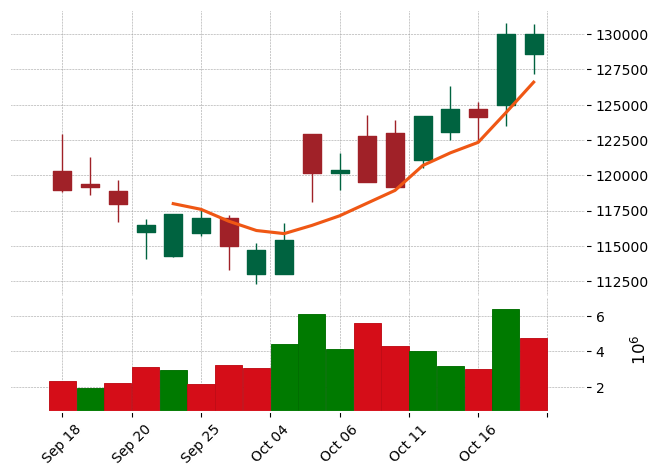

In [111]:
import mplfinance as mpf
import FinanceDataReader as fdr

plt.figure(figsize = (4, 4))

skhynix = fdr.DataReader("000660", '2023-09-18', '2023-10-18')
skhynix = skhynix[["Open", "High", "Low", "Close", "Volume"]]

mpf.plot(skhynix,
         type = 'candle', 
         style = 'charles', 
         volume = True,
         ylabel = '',
         ylabel_lower = '',
         mav = [5])

In [116]:
stock.iloc[4877:4895, :]

,index,Date,Open,High,Low,Close,...,5MA,20MA,60MA,120MA,RMI,Fluctuation
4877,5124,2023-09-18,120300,122900,118800,119000,...,119760.0,118465.0,117456.666667,107305.833333,85.405405,1
4878,5125,2023-09-19,119400,121300,118600,119200,...,120260.0,118600.0,117551.666667,107562.500000,100.000000,0
4879,5126,2023-09-20,118900,119700,116700,118000,...,120160.0,118700.0,117635.000000,107821.666667,97.297297,0
4880,5127,2023-09-21,116000,116900,114100,116500,...,119020.0,118480.0,117671.666667,108052.500000,69.756098,1
4881,5128,2023-09-22,114300,117300,114200,117300,...,118000.0,118520.0,117690.000000,108291.666667,33.136095,0
4882,5129,2023-09-25,115900,117700,115700,117000,...,117600.0,118575.0,117720.000000,108540.000000,15.822785,0
4883,5130,2023-09-26,117000,117200,113300,115000,...,116760.0,118395.0,117676.666667,108794.166667,0.000000,0
4884,5131,2023-09-27,113000,115200,112300,114700,...,116100.0,118160.0,117623.333333,109045.000000,0.000000,1
4885,5132,2023-10-04,113000,116600,113000,115400,...,115880.0,117840.0,117601.666667,109308.333333,0.000000,1
4886,5133,2023-10-05,122900,122900,118100,120200,...,116460.0,117850.0,117708.333333,109567.500000,21.481481,1


(array([5122.5, 5125. , 5127.5, 5130. , 5132.5, 5135. , 5137.5, 5140. ,
        5142.5]),
 [Text(5122.5, 0, '5122.5'),
  Text(5125.0, 0, '5125.0'),
  Text(5127.5, 0, '5127.5'),
  Text(5130.0, 0, '5130.0'),
  Text(5132.5, 0, '5132.5'),
  Text(5135.0, 0, '5135.0'),
  Text(5137.5, 0, '5137.5'),
  Text(5140.0, 0, '5140.0'),
  Text(5142.5, 0, '5142.5')])

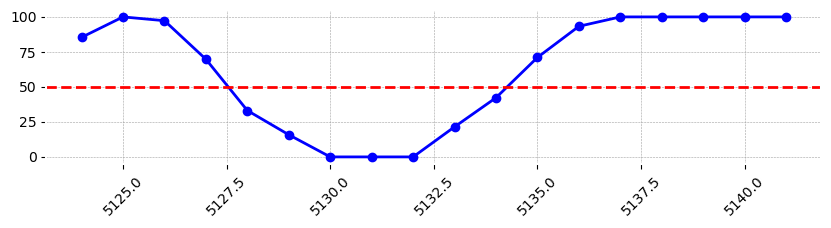

In [118]:
plt.figure(figsize = (10, 2))
stock_ = stock[["Date", "RMI", "Close", "index"]].iloc[4877:4895]
#stock_.iloc[4773: 4793]["RMI"].plot(color = 'b')
plt.plot(stock_["index"], stock_["RMI"], color='b', marker='o', linestyle='-')  # RMI 값을 점으로 표시
plt.axhline(y=50, color='r', linestyle='--')
plt.xticks(rotation = 45)